In [4]:
import os

def cargar_historias_desde_carpeta(ruta_carpeta):
    """
    Carga todas las historias de archivos TXT en una carpeta, divididas por '#'
    
    Args:
        ruta_carpeta (str): Ruta de la carpeta con archivos TXT
        
    Returns:
        list: Lista de listas de strings con todas las historias encontradas
    """
    lista_historias = []
    
    # Verificar que la carpeta exista
    if not os.path.isdir(ruta_carpeta):
        raise ValueError(f"La carpeta {ruta_carpeta} no existe")
    
    # Recorrer todos los archivos en la carpeta
    for nombre_archivo in os.listdir(ruta_carpeta):
        if nombre_archivo.endswith('.txt'):
            ruta_completa = os.path.join(ruta_carpeta, nombre_archivo)
            
            try:
                with open(ruta_completa, 'r', encoding='utf-8') as archivo:
                    contenido = archivo.read()
                    # Dividir por '#' y eliminar strings vacíos
                    historias = [h.strip() for h in contenido.split('#') if h.strip()]
                    lista_historias.append(historias)
                    
            except Exception as e:
                print(f"Error al procesar {nombre_archivo}: {str(e)}")
    
    return lista_historias


In [5]:

ruta = './Stories'  
todas_las_historias = cargar_historias_desde_carpeta(ruta)
print(f"Se cargaron {len(todas_las_historias)} listas de historias")

Se cargaron 5 listas de historias


In [6]:
from rouge_score import rouge_scorer

def compare_stories_rouge_l(historiaA: str, historiaB: str) -> dict:
    """
    Calcula la métrica ROUGE-L entre dos historias, evaluando solapamientos de secuencias largas.

    Args:
        historiaA (str): Primera historia (texto generado o referencia).
        historiaB (str): Segunda historia (texto a comparar).

    Returns:
        dict: Puntuaciones ROUGE-L (precision, recall, fmeasure).
    """
    # Inicializar el scorer con ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    # Calcular puntuaciones
    scores = scorer.score(historiaA, historiaB)
    
    return {
        'rougeL': {
            'precision': scores['rougeL'].precision,
            'recall': scores['rougeL'].recall,
            'fmeasure': scores['rougeL'].fmeasure
        }
    }


In [7]:
import pandas as pd
from itertools import combinations

def calcular_metricas_por_genero(lista_generos, funcion_rouge):
    """
    Calcula métricas ROUGE-L para pares de historias dentro de cada modelo por género
    
    Args:
        lista_generos: List[List[str]] donde cada sublista contiene 6 historias
                       (3 del Modelo A + 3 del Modelo B)
        funcion_rouge: Función que recibe 2 historias y devuelve dict con métricas ROUGE-L
    
    Returns:
        DataFrame con las métricas F1 de ROUGE-L para cada comparación
    """
    resultados = {'Modelo_A': [], 'Modelo_B': []}
    
    for genero in lista_generos:
        if len(genero) != 6:
            print(f"¡Advertencia! Género con {len(genero)} historias. Se esperaban 6.")
            continue
            
        # Separar historias
        modelo_a = genero[:3]  # Primeras 3 historias
        modelo_b = genero[3:]  # Últimas 3 historias
        
        # Calcular todas las combinaciones por pares para Modelo A
        for h1, h2 in combinations(modelo_a, 2):
            metricas = funcion_rouge(h1, h2)['rougeL']
            resultados['Modelo_A'].append(metricas['fmeasure'])
        
        # Calcular todas las combinaciones por pares para Modelo B
        for h1, h2 in combinations(modelo_b, 2):
            metricas = funcion_rouge(h1, h2)['rougeL']
            resultados['Modelo_B'].append(metricas['fmeasure'])
    
    # Crear DataFrame con los resultados
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados

C:\Users\53552\AppData\Local\Temp\ipykernel_9396\1163429629.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df.melt(), x='variable', y='value', palette='coolwarm')


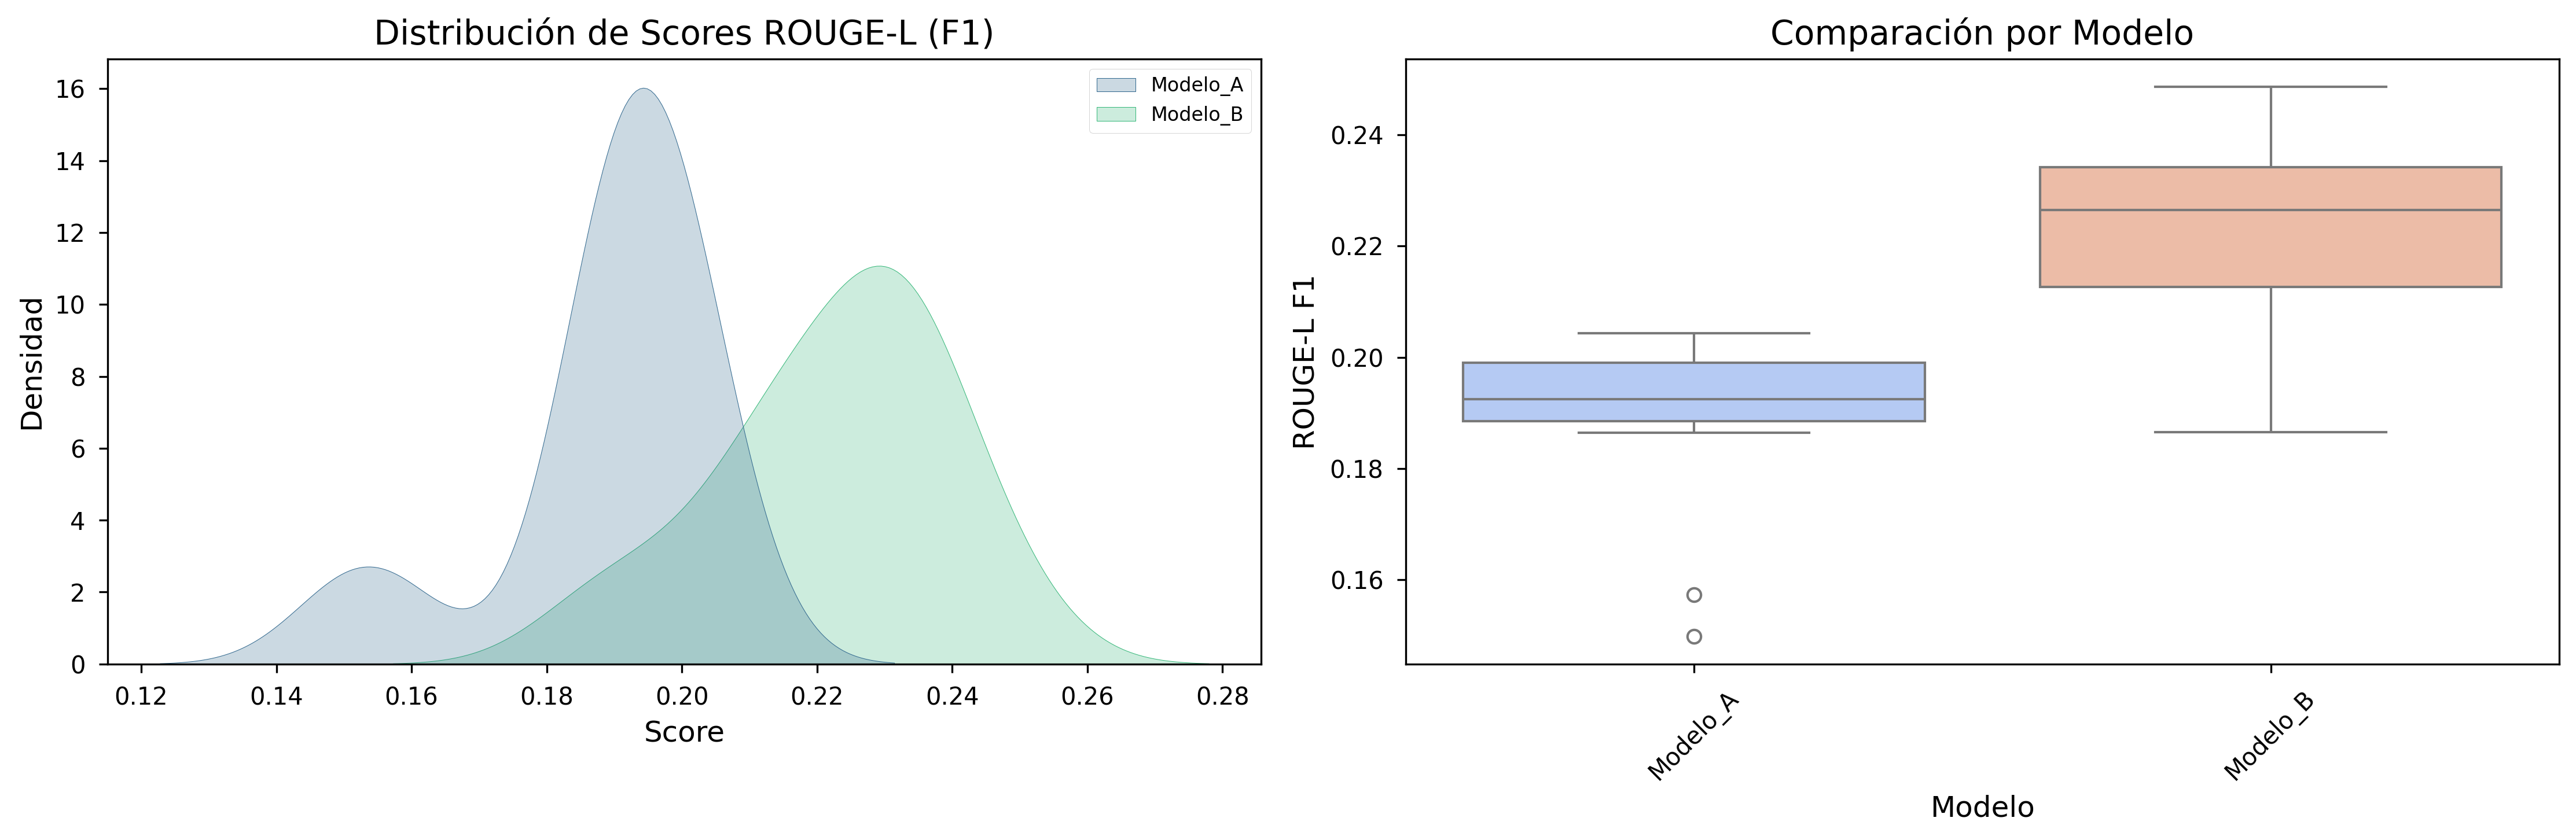

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = calcular_metricas_por_genero(todas_las_historias, compare_stories_rouge_l)

plt.figure(figsize=(15, 5))

# Gráfico KDE
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, palette='viridis', fill=True)
plt.title('Distribución de Scores ROUGE-L (F1)')
plt.xlabel('Score')
plt.ylabel('Densidad')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df.melt(), x='variable', y='value', palette='coolwarm')
plt.title('Comparación por Modelo')
plt.xlabel('Modelo')
plt.ylabel('ROUGE-L F1')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

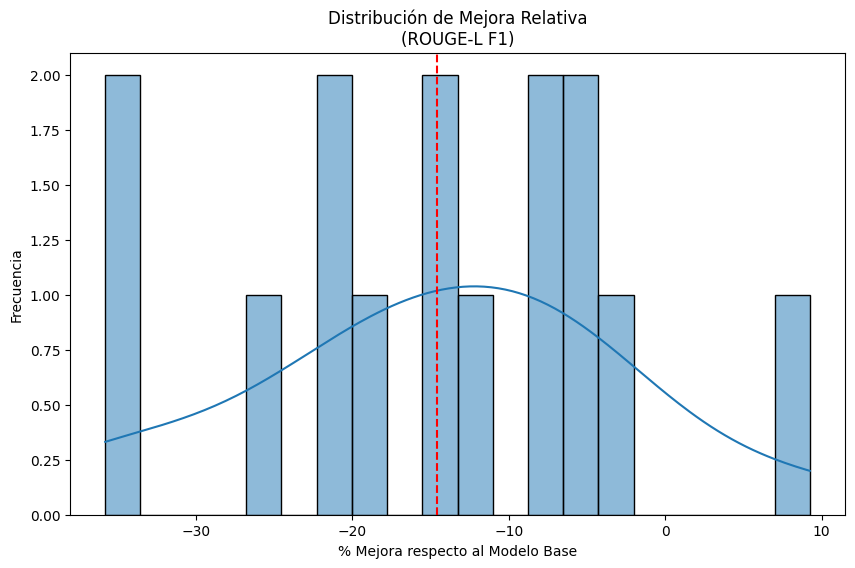

In [6]:
# Calcular mejora porcentual entre dos modelos
df['improvement'] = (df['Modelo_A'] - df['Modelo_B']) / df['Modelo_B'] * 100

# Gráfico de mejora
plt.figure(figsize=(10, 6))
sns.histplot(df['improvement'], bins=20, kde=True)
plt.axvline(df['improvement'].mean(), color='r', linestyle='--')
plt.title('Distribución de Mejora Relativa\n(ROUGE-L F1)')
plt.xlabel('% Mejora respecto al Modelo Base')
plt.ylabel('Frecuencia')
plt.show()

In [2]:
import numpy as np

UEQ_results_model_A = np.array([[10, 5, 10, 5, 10],
               [10, 6, 8, 9, 9],
               [10, 5, 6, 9, 7],
               [10, 8, 8, 9, 8],
               [10, 5, 8, 9, 8],
               [10, 3, 8, 5, 7],
               [9, 8, 5, 8, 7],
               [10, 7, 9, 9, 8],
               [10, 8, 9, 9, 8],
               [10, 8, 10, 9, 7],
               [10, 7, 9, 8, 8],
               [9, 6, 8, 9, 9]])


UEQ_results_model_B = np.array([[10, 4, 9, 4, 9],
               [10, 5, 7, 8, 8],
               [10, 4, 5, 7, 6],
               [10, 7, 7, 8, 7],
               [10, 4, 7, 8, 7],
               [10, 2, 7, 4, 6],
               [9, 7, 4, 7, 6],
               [10, 6, 8, 8, 7],
               [10, 7, 8, 8, 7],
               [10, 7, 9, 8, 6],
               [10, 6, 8, 7, 7],
               [9, 5, 7, 8, 8]])


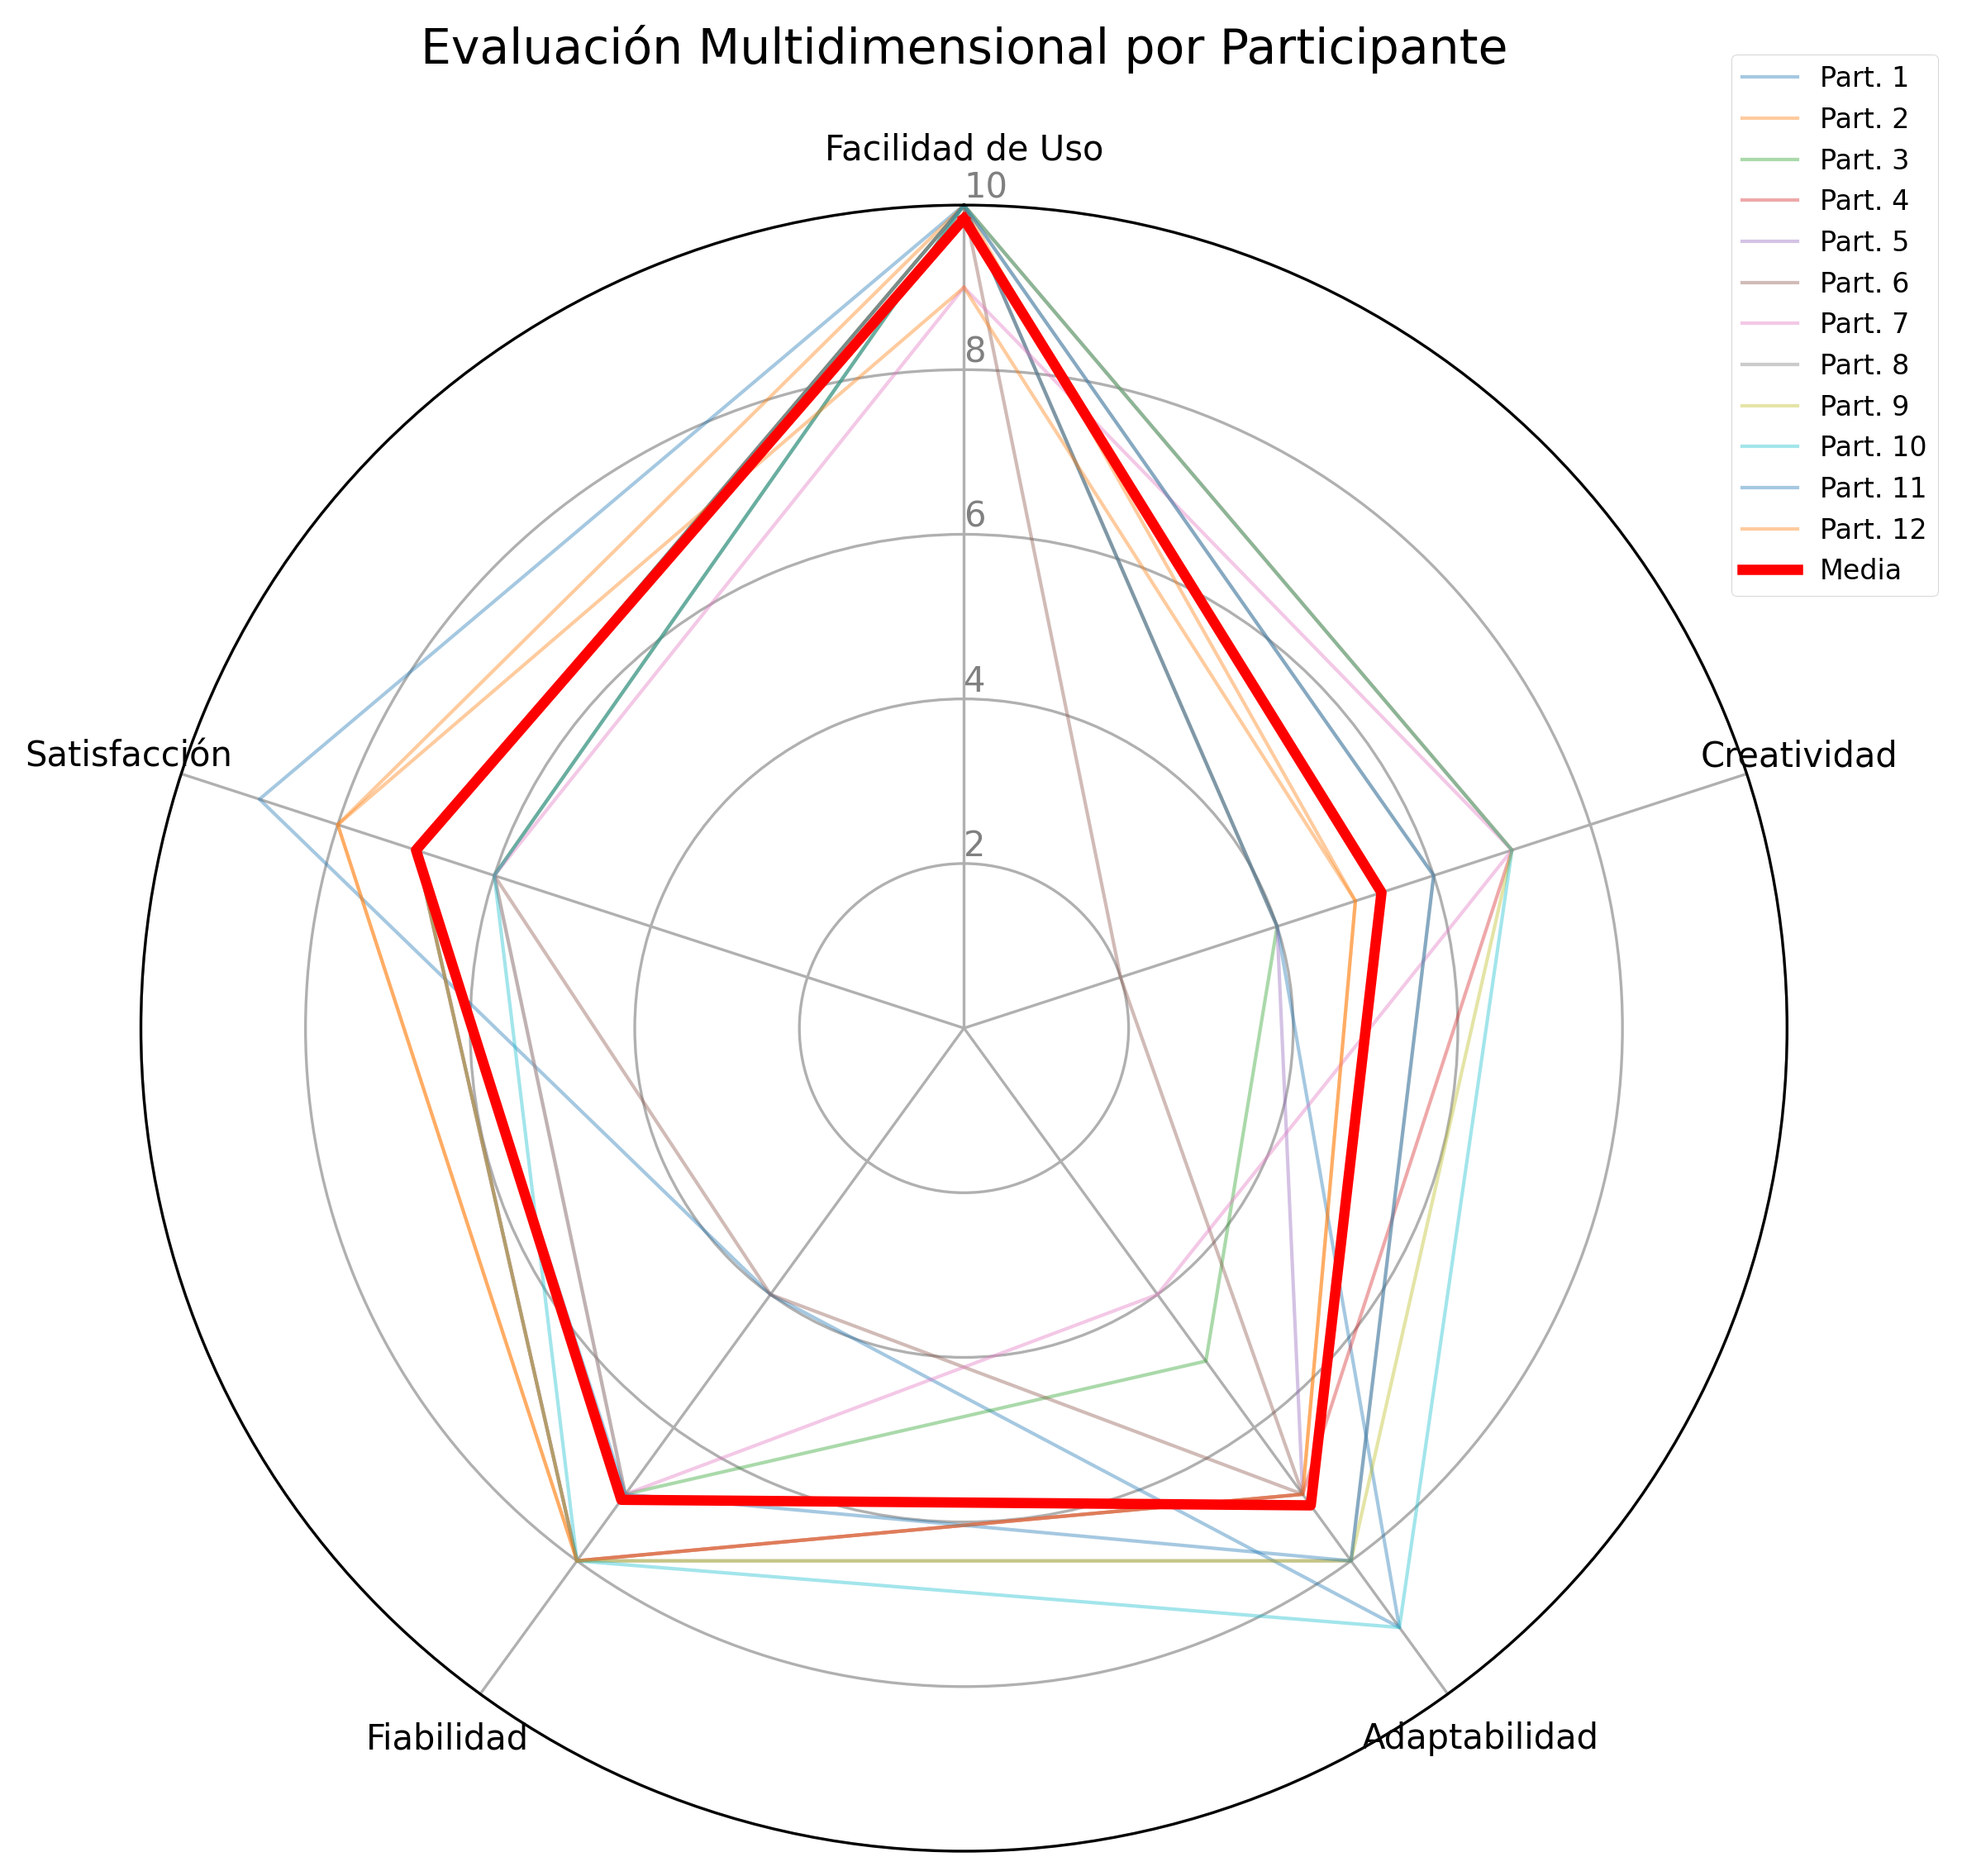

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Configuración de estilo académico
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 300
})


# Etiquetas (adaptar según tus preguntas)
categories = ['Facilidad de Uso', 'Creatividad', 'Adaptabilidad', 'Fiabilidad', 'Satisfacción']
N = len(categories)

# Ángulos para el gráfico radar
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Figura
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Plot cada participante
for i in range(len(UEQ_results_model_A)):
    values = UEQ_results_model_A[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', alpha=0.4, label=f'Part. {i+1}')

# Promedio
mean_values = np.mean(UEQ_results_model_A, axis=0).tolist()
mean_values += mean_values[:1]
ax.plot(angles, mean_values, linewidth=3, linestyle='solid', color='red', label='Media')

# Personalización
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 10)
ax.set_rlabel_position(0)
plt.yticks([2,4,6,8,10], ["2","4","6","8","10"], color="grey", size=10)
plt.title('Evaluación Multidimensional por Participante', pad=20)
plt.legend(bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.savefig('evaluacion_radar.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Calcular promedios por columna
avg_A = np.mean(UEQ_results_model_A, axis=0)
avg_B = np.mean(UEQ_results_model_B, axis=0)

# Calcular diferencia y porcentaje de mejora
difference = avg_A - avg_B
improvement_percentage = (difference / avg_B) * 100

# Nombres de los componentes (asumiendo que son los mismos que en tu pregunta anterior)
components = ['Facilidad de Uso', 'Creatividad', 'Adaptabilidad', 'Fiabilidad', 'Satisfacción']

# Mostrar resultados
print("Promedio Modelo A:", np.round(avg_A, 2))
print("Promedio Modelo B:", np.round(avg_B, 2))
print("\nPorcentaje de mejora del Modelo A respecto al Modelo B:")

for comp, percent in zip(components, improvement_percentage):
    print(f"{comp}: {percent:.2f}%")